# 🏠 Advanced Melbourne Housing Analysis
Full-featured data science workflow with feature engineering, encoding, and model comparison.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("melb_data.csv")
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


## 🧹 Data Cleaning

In [4]:
# Drop high-NaN columns and rows with missing values
df = df.drop(columns=[col for col in ["BuildingArea", "CouncilArea", "Car", "Propertycount", "Postcode"] if col in df.columns])
df = df.dropna()

# Convert date
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Clean YearBuilt
df = df[df['YearBuilt'] > 1800]

## 🛠️ Feature Engineering

In [5]:
# House Age
df['HouseAge'] = 2025 - df['YearBuilt']

# Price per Room
df['PricePerRoom'] = df['Price'] / df['Rooms']

# Luxury Area flag
top_suburbs = df.groupby("Suburb")["Price"].mean().sort_values(ascending=False).head(10).index
df['LuxuryArea'] = df['Suburb'].isin(top_suburbs).astype(int)

df[['Rooms', 'Price', 'PricePerRoom', 'HouseAge', 'LuxuryArea']].head()

,Rooms,Price,PricePerRoom,HouseAge,LuxuryArea
1,2,1035000.0,517500.000000,125.0,0
2,3,1465000.0,488333.333333,125.0,0
4,4,1600000.0,400000.000000,11.0,0
6,3,1876000.0,625333.333333,115.0,0
7,2,1636000.0,818000.000000,135.0,0


## 🏷️ Encoding Categorical Variables

In [6]:
df_encoded = pd.get_dummies(df, columns=['Type', 'Regionname'], drop_first=True)
df_encoded.head()

,Suburb,Address,Rooms,Price,Method,SellerG,Date,Distance,Bedroom2,Bathroom,...,LuxuryArea,Type_t,Type_u,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
1,Abbotsford,25 Bloomburg St,2,1035000.0,S,Biggin,2016-02-04,2.5,2.0,1.0,...,0,0,0,0,1,0,0,0,0,0
2,Abbotsford,5 Charles St,3,1465000.0,SP,Biggin,2017-03-04,2.5,3.0,2.0,...,0,0,0,0,1,0,0,0,0,0
4,Abbotsford,55a Park St,4,1600000.0,VB,Nelson,2016-06-04,2.5,3.0,1.0,...,0,0,0,0,1,0,0,0,0,0
6,Abbotsford,124 Yarra St,3,1876000.0,S,Nelson,2016-05-07,2.5,4.0,2.0,...,0,0,0,0,1,0,0,0,0,0
7,Abbotsford,98 Charles St,2,1636000.0,S,Nelson,2016-10-08,2.5,2.0,1.0,...,0,0,0,0,1,0,0,0,0,0


## 📦 Model Preparation

In [7]:
features = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Landsize',
             'Lattitude', 'Longtitude', 'HouseAge', 'PricePerRoom', 'LuxuryArea'] +              [col for col in df_encoded.columns if col.startswith('Type_') or col.startswith('Regionname_')]

X = df_encoded[features]
y = df_encoded["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


## 🤖 Model Comparison

In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append({"Model": name, "MSE": mse, "R2": r2})

pd.DataFrame(results).sort_values(by="R2", ascending=False)

,Model,MSE,R2
2,Random Forest,1.538165e+09,0.996271
1,Decision Tree,2.856583e+09,0.993075
3,Gradient Boosting,3.073886e+09,0.992548
0,Linear Regression,2.910249e+10,0.929449


## 🔍 Feature Importance (Random Forest)

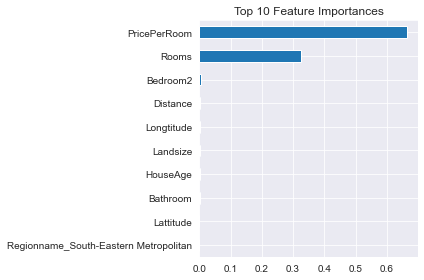

In [9]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind="barh")
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()